In [1]:
import numpy as np
import functools
import time
from matplotlib import pyplot as plt
from sklearn import datasets

# ECS7023P K-Means Algorithm Elliot Linsey

Below I have created two small datasets and imported the iris dataset from the scikit-learn library. The reason I have created the two datasets is that they have different dimensions, 1-D and 2-D. This is to make sure that the algorithm works for both 1-dimensional data and multi-dimensional data, as well as for plotting purposes.   

Both the created datasets have 3 clearly defined clusters that are suitable for K-Means clustering. There are no outliers and an equal number of datapoints per cluster which gives it a high potential for effective clustering. The iris dataset has 4 dimensions and 3 different types of iris flower. One of the flower types is clearly separated from the other two, however the other two are harder to differentiate which may affect the ability of the algorithm to effectively cluster them. To plot the iris dataset, we later on use PCA to reduce the dimensions to 2.

In [2]:
data = np.array([[1,5],
                [3,6],
                [4,2],
                [3,7],
                [5,8],
                [25,31],
                [27,33],
                [23,25],
                [31,28],
                [33,31],
                [55,54],
                [59,51],
                [63,65],
                [56,62],
                [61,61]])

data_1d = np.array([1,5,3,2,6,25,26,24,27,28,53,52,50,49,51])
iris = datasets.load_iris()

To demonstrate K-Means clustering, I will perform an example manually on the 1-D dataset. 

Firstly, we must choose a k-number. In this instance let us select k=3 so that the optimum number of clusters is selected (we only know this due to creating the custom dataset, in real life we would investigate multiple different k-numbers to find the optimum).

Once we have decided on a k-number, the algorithm randomly chooses k initial centroids, in this case 3. These centroids will be the beginning of the clusters and the values will start to group around them at first, after this the means of each cluster will be taken and the values will cluster around these. This process will continue repeating until the means no longer change, at this point the clusters will be considered stabilised.

Our 1-D data is: [1,5,3,2,6,25,26,24,27,28,53,52,50,49,51]. 

If our initial random centroids are designated as 25,28 and 49, the initial clusters would be: 

25:[25,26,24,6,5,3,2,1]

28:[28,27]

49:[49,50,51,52,53]

The means of these initial clusters are [11.5,27.5,51]. If we now recluster the values around these cluster means, we get:

11.5:[6,5,3,2,1]

27.5:[24,25,26,27,28]

51:[49,50,51,52,53]

Finding the means of these values results in [3.4,26,51]. If we were to recluster around these means we would end up with the same clusters. In this case the clusters would be considered stabilised as the means have not moved between iterations and these clusters would be our final clusters.   


## Testing

To follow a test-driven development cycle, I will first implement pseudo-code to establish what types of tests I will need. 

Assert that the choice of k results in k initial centroids. 

Assert that a list of k initial centroids is returned from randomly selecting them.

Assert that the clustering function is grouping points with the smallest distance from the centroid/previous cluster mean.

Assert that the update function is adequately finding the means of the centroids, then feeding them back into the clustering function to be reclustered.

I use a timer to find how long the function takes to run. 

In [3]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start = time.perf_counter()
        #'value' is the function being timed
        value = func(*args, **kwargs)
        end = time.perf_counter()
        print(f'Finished {func.__name__!r} in {end-start:.8f} seconds!')
        return value
    return wrapper_timer

Below is my K-Means function that has been constructed as a class. It takes two parameters to initialise, these being the data that is being clustered and the k number.

After initialisation, the initial centroids are randomly selected according to k number (*ini_centroids()*). These data values are then clustered around these initial centroids (*clusters()*) by finding the minimum distances between each data value and each centroid, then appending the data value to the closest centroid. 

Once clustering is complete, the means of the clusters are calculated and become the new centroids (*update()*), these are fed back into the clusters function where the data points are again clustered around these new centroids. 

The full function (*k_means_func()*) repeats this process until the means have stabilised, it then returns the final clusters. 

An extension of *k_means_func()* is *k_means_repeat(i)*, this repeats the *k_means_func()* process *i* times, saving a total of each clustering processes variance. At the end of these *i* repeats, it selects the *k_means_func()* results with the lowest variance, these being the most optimally clustered values within the *i* repetitions. Within the demonstrations, I use *i*=10. 

There are two plotting functions, *plot()* and *plot_repeat(i)*. The only difference being that *plot()* calls the initial *k_means_func()* and plots those results, so there is no repetition of the k means process. *plot_repeat(i)* uses the *k_means_repeat(i)* function so it is plotting the optimum clusters (within *i* repeats). Both can take 1D or 2D datasets to plot, but cannot plot any more dimensions than that.  

In [19]:
class k_means():
    def __init__(self, data, k):
        self.data = data
        self.k = k
        if len(data) == 0:
            print('Error: Empty data. Input non-empty numpy array!')
        elif k <= 0:
            print('Error: K number must be greater than 0!')
    def ini_centroids(self, data, k): #Limit: Cannot initialise more k numbers than numbers of values in sample
        lst = []
        data_len = len(self.data)
        choices = np.random.choice(range(data_len), size=self.k, replace=False)
        for i in choices:
            lst.append([self.data[i]])
        return [i[0] for i in lst]
    def clusters(self,centroids):
        cluster_vals = [[] for i in range(len(centroids))]
        for y in self.data:
            distances = []
            for x in centroids:
                distances.append(np.linalg.norm(y - x))
            idx = distances.index(min(distances))
            cluster_vals[idx].append(y)
        #Had an issue where depending on the centroids, all values would leave their cluster as 
        #they would be closerto another cluster's mean, leaving an empty cluster.
        #In this case, the empty cluster has the mean reappended before updating 
        #to prevent a divide by zero error. 
        for i in range(len(cluster_vals)):
            if len(cluster_vals[i]) == 0:
                cluster_vals[i].append(centroids[i])            
        return cluster_vals
    def update(self,clust_vals):
        cluster_means = []       
        for x in clust_vals:
            cluster_means.append(sum(x[::])/len(x))
        return self.clusters(cluster_means)
    #@timer
    def k_means_func(self):
        centroids = self.ini_centroids(self.data, self.k)
        cluster_values = self.clusters(centroids)
        updates = self.update(cluster_values)
        for i in range(len(updates)):
            if not np.array_equal(np.round(updates[i][0],3), np.round(self.update(updates)[i][0],3)):
                updates = self.update(updates)
        return updates
    @timer
    def k_means_repeat(self,i):
        clusters = []
        variances = []
        for r in range(i):
            clusters.append(self.k_means_func())
        for x in clusters:
            count = 0
            for i in range(self.k):
                count += np.var(x[i])
            variances.append(count)
        return clusters[variances.index(np.min(variances))]
    def plot(self): #Limit: for plotting purposes cannot use a k number more than the numbers of 
                    #colours in colors.
                    #This can be remedied by adding more colors. 
                    #Limit: Can only be used with 1D and 2D data. 
        test_plot = self.k_means_func()
        test_array = np.array([np.array(xi) for xi in test_plot],dtype=object)
        colors = ['red','green','blue','purple','orange','brown','pink','olive','cyan','gray']
        if self.data.ndim != 1:
            #It plots a circle for each datapoint in each cluster, then an x for each cluster mean. 
            #The colors list ensures that both datapoints and cluster mean are the same colour.
            for i in range(self.k):
                plt.scatter(test_array[i][:,0], test_array[i][:,1], color = colors[i])
                plt.scatter(np.mean(test_array[i][:,0]), np.mean(test_array[i][:,1]), marker='x', s=80, 
                            color=colors[i])
            plt.show()
        else:
            #If the data is 1D, it turns all the clusters into 2D by appending a 0 for the y-value.
            for i in range(self.k):
                plt.plot(test_plot[i], [0]*len(test_plot[i]), 'o',color = colors[i])
                plt.plot(np.mean(test_plot[i]), [0],'x', markersize=15,color = colors[i])
            plt.show()
        #Returns the plot and the corresponding clusters as a list of lists
        return test_plot
    def plot_repeat(self,i): #Limit: the same color limit as above.
                             #Limit: Can only be used with 1D and 2D data.
        test_plot = self.k_means_repeat(i)
        test_array = np.array([np.array(xi) for xi in test_plot],dtype=object)
        colors = ['red','green','blue','purple','orange','brown','pink','olive','cyan','gray']
        if self.data.ndim != 1:
            for i in range(self.k):
                plt.scatter(test_array[i][:,0], test_array[i][:,1], color = colors[i])
                plt.scatter(np.mean(test_array[i][:,0]), np.mean(test_array[i][:,1]), marker='x', s=80, 
                            color=colors[i])
            plt.show()
        else:
            for i in range(self.k):
                plt.plot(test_plot[i], [0]*len(test_plot[i]), 'o',color = colors[i])
                plt.plot(np.mean(test_plot[i]), [0],'x', markersize=15,color = colors[i])
            plt.show()
        return test_plot

### Function demonstrations

The function outputs the clusters as a list of lists filled with numpy arrays. This means you can access each cluster with usual list indexing.

I have only used the timer for the *k_means_repeat()* function and not the basic *k_means_func()*. This is because you get *i* timer informations when you use *k_means_repeat()* as it produces the time for each repetition of the normal function. To get a rough estimate of how long the usual function runs for a dataset, you can divide the resulting *k_means_repeat()* time by *i*. 

Here are the original datasets, plotted on graphs.

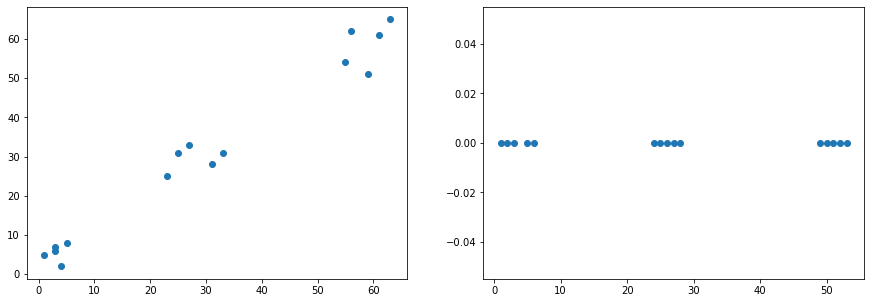

In [5]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.scatter(data[:,0],data[:,1])
ax2.plot(data_1d,[0]*len(data_1d),'o')
plt.show()

Finished 'k_means_repeat' in 0.01482560 seconds!


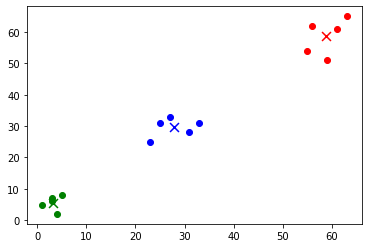

[[array([55, 54]),
  array([59, 51]),
  array([63, 65]),
  array([56, 62]),
  array([61, 61])],
 [array([1, 5]), array([3, 6]), array([4, 2]), array([3, 7]), array([5, 8])],
 [array([25, 31]),
  array([27, 33]),
  array([23, 25]),
  array([31, 28]),
  array([33, 31])]]

In [6]:
test = k_means(data, 3)  
test.k_means_func()
#test.k_means_repeat()

test.plot_repeat(10)

In [7]:
test.k_means_repeat(10)

Finished 'k_means_repeat' in 0.01766350 seconds!


[[array([55, 54]),
  array([59, 51]),
  array([63, 65]),
  array([56, 62]),
  array([61, 61])],
 [array([25, 31]),
  array([27, 33]),
  array([23, 25]),
  array([31, 28]),
  array([33, 31])],
 [array([1, 5]), array([3, 6]), array([4, 2]), array([3, 7]), array([5, 8])]]

In [8]:
test.k_means_func()

[[array([55, 54]),
  array([59, 51]),
  array([63, 65]),
  array([56, 62]),
  array([61, 61])],
 [array([1, 5]), array([3, 6]), array([4, 2]), array([3, 7]), array([5, 8])],
 [array([25, 31]),
  array([27, 33]),
  array([23, 25]),
  array([31, 28]),
  array([33, 31])]]

Finished 'k_means_repeat' in 0.02033110 seconds!


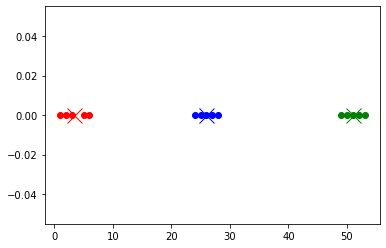

[[1, 5, 3, 2, 6], [53, 52, 50, 49, 51], [25, 26, 24, 27, 28]]

In [9]:
one_d = k_means(data_1d,3)
one_d.plot_repeat(10)

Using k as the maximum number of samples returns each sample on its own. 

In [10]:
one_d = k_means(data_1d,15)
one_d.k_means_repeat(10)

Finished 'k_means_repeat' in 0.26401510 seconds!


[[50],
 [3],
 [27],
 [2],
 [52],
 [51],
 [53],
 [1],
 [6],
 [26],
 [25],
 [24],
 [28],
 [5],
 [49]]

It can plot with different k numbers (up to 10 in this iteration, however this can be increased by adding more colours to the colors list in the plotting function). 

Finished 'k_means_repeat' in 0.04171140 seconds!


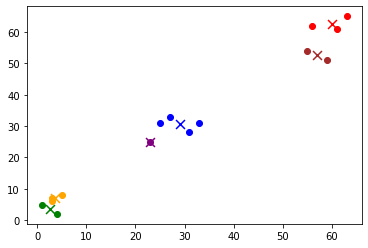

[[array([63, 65]), array([56, 62]), array([61, 61])],
 [array([1, 5]), array([4, 2])],
 [array([25, 31]), array([27, 33]), array([31, 28]), array([33, 31])],
 [array([23, 25])],
 [array([3, 6]), array([3, 7]), array([5, 8])],
 [array([55, 54]), array([59, 51])]]

In [11]:
one_d = k_means(data,6)
one_d.plot_repeat(10)

The function also works on a combination of positive and negative values.

Finished 'k_means_repeat' in 0.01954600 seconds!


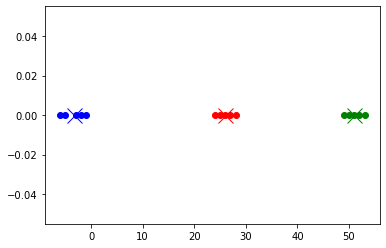

[[25, 26, 24, 27, 28], [53, 52, 50, 49, 51], [-1, -5, -3, -2, -6]]

In [12]:
data_1d_neg = np.array([-1,-5,-3,-2,-6,25,26,24,27,28,53,52,50,49,51])
data_1d_neg_k = k_means(data_1d_neg,3)
data_1d_neg_k.plot_repeat(10)

When empty data is put into the algorithm initialisation, a message is printed out alerting you to the problem. A message is also printed if K is equal to or less than 0. 

In [20]:
data_0 = np.array([])
no_data_k = k_means(data_0,3)
no_data_k

data_0 = np.array([1,2,3])
no_data_k = k_means(data_0,0)
no_data_k

Error: Empty data. Input non-empty numpy array!
Error: K number must be greater than 0!


My function works on multidimensional datasets such as the iris dataset. However, it is difficult to tell how accurate it is in this format. 

In [14]:
iris_k = k_means(iris['data'],3)
iris_k.k_means_repeat(10)

Finished 'k_means_repeat' in 0.11168160 seconds!


[[array([5.1, 3.5, 1.4, 0.2]),
  array([4.9, 3. , 1.4, 0.2]),
  array([4.7, 3.2, 1.3, 0.2]),
  array([4.6, 3.1, 1.5, 0.2]),
  array([5. , 3.6, 1.4, 0.2]),
  array([5.4, 3.9, 1.7, 0.4]),
  array([4.6, 3.4, 1.4, 0.3]),
  array([5. , 3.4, 1.5, 0.2]),
  array([4.4, 2.9, 1.4, 0.2]),
  array([4.9, 3.1, 1.5, 0.1]),
  array([5.4, 3.7, 1.5, 0.2]),
  array([4.8, 3.4, 1.6, 0.2]),
  array([4.8, 3. , 1.4, 0.1]),
  array([4.3, 3. , 1.1, 0.1]),
  array([5.8, 4. , 1.2, 0.2]),
  array([5.7, 4.4, 1.5, 0.4]),
  array([5.4, 3.9, 1.3, 0.4]),
  array([5.1, 3.5, 1.4, 0.3]),
  array([5.7, 3.8, 1.7, 0.3]),
  array([5.1, 3.8, 1.5, 0.3]),
  array([5.4, 3.4, 1.7, 0.2]),
  array([5.1, 3.7, 1.5, 0.4]),
  array([4.6, 3.6, 1. , 0.2]),
  array([5.1, 3.3, 1.7, 0.5]),
  array([4.8, 3.4, 1.9, 0.2]),
  array([5. , 3. , 1.6, 0.2]),
  array([5. , 3.4, 1.6, 0.4]),
  array([5.2, 3.5, 1.5, 0.2]),
  array([5.2, 3.4, 1.4, 0.2]),
  array([4.7, 3.2, 1.6, 0.2]),
  array([4.8, 3.1, 1.6, 0.2]),
  array([5.4, 3.4, 1.5, 0.4]),
  array(

I use PCA to reduce the iris dataset to 2 dimensions, then convert them to numpy and plot them using my k means function. It appears to be accurate at identifying the flower on the left, but results for the two flowers on the right varies depending on the inital centroids.

In [15]:
from sklearn.decomposition import PCA
import pandas as pd
numComponents = 2
pca = PCA(n_components=numComponents)
pca.fit(iris['data'])

projected = pca.transform(iris['data'])
projected = pd.DataFrame(projected,columns=['pc1','pc2'],index=range(0,len(iris['data'])))
projected.head()

,pc1,pc2
0,-2.684126,0.319397
1,-2.714142,-0.177001
2,-2.888991,-0.144949
3,-2.745343,-0.318299
4,-2.728717,0.326755


Finished 'k_means_repeat' in 0.12850940 seconds!


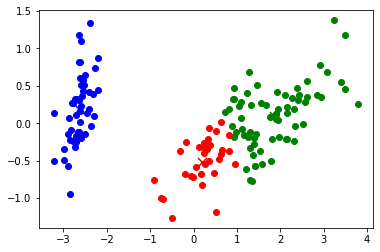

[[array([ 0.18331772, -0.82795901]),
  array([ 0.64166908, -0.41824687]),
  array([-0.74912267, -1.00489096]),
  array([-0.0087454 , -0.72308191]),
  array([-0.50784088, -1.26597119]),
  array([ 0.51169856, -0.10398124]),
  array([ 0.26497651, -0.55003646]),
  array([-0.17392537, -0.25485421]),
  array([ 0.66028376, -0.35296967]),
  array([ 0.23610499, -0.33361077]),
  array([ 0.94473373, -0.54314555]),
  array([ 0.04522698, -0.58383438]),
  array([ 0.35788842, -0.06892503]),
  array([ 0.81329065, -0.1633503 ]),
  array([-0.30558378, -0.36826219]),
  array([-0.06812649, -0.70517213]),
  array([-0.18962247, -0.68028676]),
  array([ 0.13642871, -0.31403244]),
  array([ 0.58800644, -0.48428742]),
  array([ 0.81509524, -0.37203706]),
  array([ 0.24595768, -0.2685244 ]),
  array([ 0.16641322, -0.68192672]),
  array([ 0.46480029, -0.67071154]),
  array([ 0.23054802, -0.40438585]),
  array([-0.70453176, -1.01224823]),
  array([ 0.35698149, -0.50491009]),
  array([ 0.33193448, -0.21265468]),
 

In [16]:
projected_np = projected.to_numpy()
projected_np
projected_k = k_means(projected_np,3)
projected_k.plot_repeat(10)

### Time Complexity

The time complexity of the algorithm is $O(n^2)$, where n is the number of clusters (K). This is because it has to iterate through every point in our data values and calculate the distance to each centroid using a nested loop (in the *clusters()* function), then cluster around the centroid with the minimum distance. Depending on how long it takes the clusters to stabilise will affect the time for the algorithm as well. 

As seen above, the iris dataset (reduced to 2D) with 150 values takes just less than 10x time to cluster as our own 2D dataset with 15 values (0.5 and 0.08 seconds). In this case, multiplying the number of samples by 10 also multiplies the amount of time to cluster by approximately 10. As I am using the *k_means_repeat(i)* function that repeats the process *i* times, this may vary depending on the randomness of each clustering process.  

### Test Harness

The test harness asserts the basic requirements I stated earlier. For the clustering and updating tests, I figured out how the data should cluster by hand, then compared these results to what I achieve through the function. 

In [17]:
import unittest

class test_kmeans(unittest.TestCase):
    #Asserting that k number of centroids are initialised
    def test_size_of(self):
        testing = k_means(data_1d,3)
        centroids = testing.ini_centroids(data_1d,3)
        self.assertEqual(len(centroids), 3)
        testing2 = k_means(data_1d,6)
        centroids2 = testing2.ini_centroids(data_1d,6)
        self.assertEqual(len(centroids2), 6)
        testing3 = k_means(data_1d,9)
        centroids3 = testing3.ini_centroids(data_1d,9)
        self.assertEqual(len(centroids3), 9)
    #Asserting that the centroids are created as lists
    def test_type_check(self):
        testing = k_means(data_1d,3)
        centroids = testing.ini_centroids(data_1d,3)
        self.assertEqual(type(centroids), list)
    #Asserting that the clustering function works as expected, I've figured out the optimum clusters
    #that they should go into by hand
    def test_cluster(self):
        testing = k_means(data_1d,3)
        self.assertEqual(testing.clusters([25,28,49]),[[1, 5, 3, 2, 6, 25, 26, 24], [27, 28], 
                                                       [53, 52, 50, 49, 51]])
        testing2 = k_means(data_1d,6)
        self.assertEqual(testing2.clusters([25,28,49,3,53,5]),[[25, 26, 24], [27, 28], [50, 49, 51], 
                                                               [1, 3, 2], [53, 52], [5, 6]])
        testing3 = k_means(data_1d,2)
        self.assertEqual(testing3.clusters([53,51]),[[53, 52], [1, 5, 3, 2, 6, 25, 26, 24, 27, 28, 50, 49, 51]])
    #Asserting that the update function is reclustering properly
    def test_update(self):
        testing = k_means(data_1d, 3)
        self.assertEqual(testing.update([[25,26,24,6,5,3,2,1],[28,27],[49,50,51,52,53]]),
                                        [[1, 5, 3, 2, 6], [25, 26, 24, 27, 28], [53, 52, 50, 49, 51]])
        testing2 = k_means(data_1d, 6)
        self.assertEqual(testing.update([[25], [26], [1, 5, 3, 2, 6, 24], [27], [28], [53, 52, 50, 49, 51]]),
                        [[25, 24], [26], [1, 5, 3, 2, 6], [27], [28], [53, 52, 50, 49, 51]])
    #asserting that the test functions are working
    def test_testing(self):
        self.assertEqual(5,5)
if __name__ == '__main__':
    unittest.main(argv=['this-is-ignored'],exit=False,verbosity=2)

test_cluster (__main__.test_kmeans) ... ok
test_size_of (__main__.test_kmeans) ... ok
test_testing (__main__.test_kmeans) ... ok
test_type_check (__main__.test_kmeans) ... ok
test_update (__main__.test_kmeans) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.007s

OK


## Final Analysis

Overall, my algorithm works with 1D and multidimensional data, with the ability to plot 1D and 2D visualisations. It assumes an input of a 1D or 2D numpy array, but it can work with multiple dimensions of variables within these arrays. It can use any k number greater than 0, however in this iteration it will only plot up to 10 k numbers but this can be increased by adding more colours. The function repeats the clustering process until the means have stabilised, there is no hard limit. It contains a repeat function that will repeat the full process a user specified number of times, returning the resulting clusters with the least variance, this is also linked to a plot function. 

A limitation may be its inability to classify outliers, if there is a datapoint far from any cluster (a global outlier), it will still be appended to a cluster and may skew the cluster mean calculations. 

It operates at a $O(n^2)$ run time because of the nested loop, and the time will vary due to the randomness of the centroid selection and the amount of times the algorithm has to repeat to stabilise the means. This may be a limitation as the algorithm runtime will increase quicker than a $O(n)$ as more k numbers and larger datasets are used, as each datapoint must be compared to each centroid in the nested loop. This means that it may reach a limit of k numbers and dataset size earlier than a $O(n)$ algorithm. From our function demonstrations above, it took 1.05 seconds to cluster the 1D dataset with 15 datapoints with a k number of 15 compared to 0.48 seconds in clustering the full iris dataset of 150 datapoints, 4 dimensions but with a k number of only 3. From this, it appears that the k number has the greater impact on algorithm runtime.

Overall it appears stable, something to work on may be implementing a sorting algorithm so that the returned clusters are sorted in ascending order as right now they are returned by the order of the initial centroids, which is random. 

Thanks for reading! 

Elliot Linsey, QMUL